In [1]:
!qbraid jobs enable qiskit

You have already enabled qBraid Quantum Jobs in the qiskit environment.


In [1]:
import qiskit
from qiskit import QuantumCircuit, assemble, Aer
from math import pi, sqrt
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.circuit.library import XXPlusYYGate
from qiskit import *
from qiskit import transpile
from itertools import combinations as combs
import scipy
from scipy import *
from IPython.display import clear_output
import matplotlib.pyplot as plt
from qiskit.algorithms.optimizers import SPSA
sim = Aer.get_backend('qasm_simulator')
import numpy as np
import random

In [ ]:
# edges = [[0,1],[2,3]]
# qc = QuantumCircuit(4,4)
# qc.x(0)
# qc.x(1)
# alpha_list = [1,2]
# beta_list = [1,0]
# for a,b in zip(alpha_list,beta_list):
#     pH(a,qc,edges)
#     mH(b,qc)
# qc.measure([x for x in range(qc.num_qubits)],[x for x in range(qc.num_qubits)])
# counts = execute(qc,sim,shots=1000).result().get_counts(qc)
# print(counts)
# for count in counts.keys():
#     print(count,score_k(count,edges))
# scorer(counts,edges)

In [11]:
def score_k(k,edges):
    sum1=0
    for edge in edges:
        sum1 += int(k[edge[0]])|int(k[edge[1]])
    return sum1

def scorer(counts,edges):
    # dic=dict()
    tot_score = 0
    for k in counts.keys():
        #print(k,score_k(k,edges))
        scr=score_k(k,edges)
        # if scr not in dic:
        #     dic[scr]=0
        # dic[scr]+=counts[k]
        tot_score += counts[k]/sum(counts.values())*scr
    # print(dic)
    return -tot_score
                    
def pH(alpha,qc,edges):
    for v_i,v_j in edges:
        qc.rz(-alpha/4,v_i)
        qc.rz(-alpha/4,v_j)
        qc.cx(v_i,v_j)
        qc.rz(-alpha/4,v_j)
        qc.cx(v_i,v_j)
        
def mH(beta,qc):
    for v_i,v_j in list(combs([x for x in range(qc.num_qubits)],2)):
        qc.append(XXPlusYYGate(beta),[v_i,v_j])

def hamiltonian_evolution_score(alpha_beta_list,args):
    edges = args[0]
    n = args[1]
    init_state = args[2]
    
    assert(len(init_state) <= n)
    global qc
    qc = QuantumCircuit(n,n)
    for i in init_state:
        qc.x(i)
    alpha_list = alpha_beta_list[:len(alpha_beta_list)//2]
    beta_list = alpha_beta_list[len(alpha_beta_list)//2:]
    for a,b in zip(alpha_list,beta_list):
        pH(a,qc,edges)
        mH(b,qc)
    qc.measure([x for x in range(qc.num_qubits)],[x for x in range(qc.num_qubits)])
    counts = execute(qc,sim,shots=1000).result().get_counts(qc)
    score = scorer(counts,edges)
    # print(score)
    return score

info = []

def callback(x):
    info.append(hamiltonian_evolution_score(x,args=[edges,n,init_state]))
    plt.plot(info)
    plt.show()
    clear_output(wait=True)
    # return hamiltonian_evolution_score(x,[qc,edges])

def solver(edges,alpha_list,beta_list,n,init_state):
    a_b_new = scipy.optimize.minimize(hamiltonian_evolution_score,alpha_list+beta_list,args=[edges,n,init_state],callback=callback,method='Nelder-Mead')
    return a_b_new
     

In [ ]:
# edges = [[0,1],[2,3]]
# alpha_list = [1,2]
# beta_list = [1,0]
# mat = np.zeros((10,10))
# args = edges
# for a in range(10):
#     print(a)
#     for b in range(10):
#         alpha = np.linspace(0,np.pi,10)[a]
#         beta = np.linspace(0,np.pi,10)[b]
#         alpha_beta_list = [alpha]*10+[beta]*10
#         mat[a][b] = hamiltonian_evolution_score(alpha_beta_list,args)
# print(mat.max())
# print(mat)

In [ ]:
# a = 0
# b = 4
# qc = QuantumCircuit(4,4)
# qc.x(0)
# qc.x(1)
# edges = args
# alpha = np.linspace(0,np.pi,10)[a]
# beta = np.linspace(0,np.pi,10)[b]
# alpha_beta_list = [alpha]*10+[beta]*10
# for a,b in zip(alpha_list,beta_list):
#     pH(a,qc,edges)
#     mH(b,qc)
# qc.measure([x for x in range(qc.num_qubits)],[x for x in range(qc.num_qubits)])
# counts = execute(qc,sim,shots=1000).result().get_counts(qc)
# print(counts)

In [12]:
global circ, edges

# edges = [[0,1],[2,3]]
# alpha_list = [1,2]
# beta_list = [2,0]
# n = 4
# k = 2
# init_state = random.sample(range(n),k)
# opt_sol = 2
edges = [[0,1],[2,3]]
alpha_list = [1,2]
beta_list = [2,0]
n = 4
k = 2
init_state = random.sample(range(n),k)
opt_sol = 2
print(init_state)
res = solver(edges,alpha_list,beta_list,n,init_state)

alpha_beta_opt = res.x

print(alpha_beta_opt)
print(hamiltonian_evolution_score(alpha_beta_opt,args=[edges,n,init_state]))
print(hamiltonian_evolution_score(alpha_beta_opt,args=[edges,n,init_state])/opt_sol)

# counts = execute(circ,sim,shots=1000).result().get_counts(circ)
# print(counts)
# print(scorer(counts,[[0,1],[2,3]]))
# circ.draw()

[ 6.40008545e-01  1.85889893e+00  2.70469971e+00 -4.90905762e-04]
-2.0
-0.9995


[1, 3]


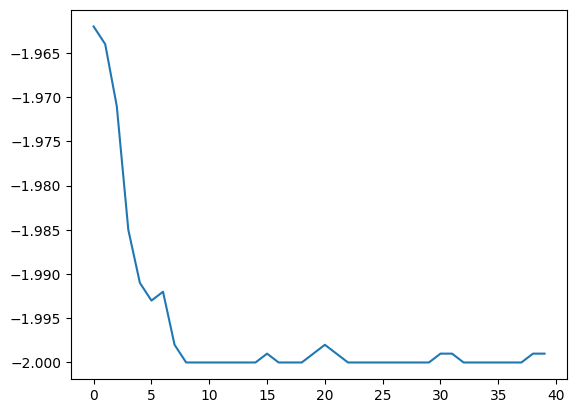

In [13]:
print(init_state)
plt.plot(info)

In [ ]:
# from qiskit.circuit.library import XXPlusYYGate
# from qiskit import transpile

In [ ]:
# circ = QuantumCircuit(2)
# circ.append(XXPlusYYGate(1.3),[0,1])
# circ = transpile(circ,basis_gates=['id','x','rz','sx','cx'])
# circ.draw('mpl')